# Fast Campus Data Science School 7th

## Regression Team Project

- Team: Team B-5 committer (김선웅, 이영인, 장승우)
- Subject: New York City Taxi Trip Duration
- Purpose: Building model 

In [48]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 
import sklearn as sk

from patsy import dmatrix

import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

import warnings
warnings.filterwarnings("ignore")

In [90]:
train = pd.read_csv("../../dataset/train.csv", parse_dates=["pickup_datetime", "dropoff_datetime"])
print("Shape of Training Data: ", train.shape)

Shape of Training Data:  (1458644, 11)


In [91]:
test = pd.read_csv("../../dataset/test.csv", parse_dates=["pickup_datetime"])
print("Shape of Test Data: ", test.shape)

Shape of Test Data:  (625134, 9)


## 1. train data의 기본 정보 탐색 및 전처리

#### 1. train data의 구성
    - shape
    - info
    - describe

#### 2. 기초 전처리
    - datetime parsing
    - distance 계산
    - 클래스가 2개인 카테고리 binary 형태로 변경

In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [74]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null datetime64[ns]
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 42.9+ MB


In [92]:
print("training data에만 있는 features: ", set(train.columns) - set(test.columns))

training data에만 있는 features:  {'trip_duration', 'dropoff_datetime'}


In [52]:
train.describe().round(3)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [96]:
train["pickup_month"] = train["pickup_datetime"].dt.month
train["dropoff_month"] = train["dropoff_datetime"].dt.month

train["pickup_weekday"] = train["pickup_datetime"].dt.weekday
train["dropoff_weekday"] = train["dropoff_datetime"].dt.weekday

train["pickup_hour"] = train["pickup_datetime"].dt.hour
train["dropoff_hour"] = train["dropoff_datetime"].dt.hour

train.shape

(1458644, 17)

In [97]:
test["pickup_month"] = train["pickup_datetime"].dt.month
test["pickup_weekday"] = train["pickup_datetime"].dt.weekday
test["pickup_hour"] = train["pickup_datetime"].dt.hour

test.shape

(625134, 12)

In [99]:
working_day = [0, 1, 2, 3, 4] # Mon-Fri
train["working_day"] = train["pickup_weekday"].isin(working_day).astype(int)

In [100]:
train["store_and_fwd_flag"] = 1 * (train.store_and_fwd_flag.values == 'Y')

In [101]:
lat1, lng1, lat2, lng2 = (train['pickup_latitude'].values, train2['pickup_longitude'].values, 
                          train2['dropoff_latitude'].values, train2['dropoff_longitude'].values)

In [102]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [103]:
def bearing_array(lat1, lng1, lat2, lng2):
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return (np.degrees(np.arctan2(y, x)) + 360) % 360 # from -180/180 to 0/360

In [104]:
train = train.assign(distance = haversine_array(lat1, lng1, lat2, lng2))
train = train.assign(bearing = bearing_array(lat1, lng1, lat2, lng2))

In [105]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 20 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null int64
trip_duration         1458644 non-null int64
pickup_month          1458644 non-null int64
dropoff_month         1458644 non-null int64
pickup_weekday        1458644 non-null int64
dropoff_weekday       1458644 non-null int64
pickup_hour           1458644 non-null int64
dropoff_hour          1458644 non-null int64
working_day           1458644 non-null int64
distance              1458644 non-null float64
bea

In [106]:
train2.describe().round(3)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,dropoff_month,pickup_weekday,dropoff_weekday,pickup_hour,dropoff_hour,working_day,distance,bearing
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,0.006,959.492,3.517,3.517,3.050,3.054,13.606,13.599,0.715,3.441,153.406
std,0.499,1.314,0.071,0.033,0.071,0.036,0.074,5237.432,1.681,1.681,1.954,1.957,6.400,6.484,0.452,4.297,104.220
min,1.000,0.000,-121.933,34.360,-121.933,32.181,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,0.000,397.000,2.000,2.000,1.000,1.000,9.000,9.000,0.000,1.232,44.305
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,0.000,662.000,4.000,4.000,3.000,3.000,14.000,14.000,1.000,2.094,168.517
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,0.000,1075.000,5.000,5.000,5.000,5.000,19.000,19.000,1.000,3.875,224.361
max,2.000,9.000,-61.336,51.881,-61.336,43.921,1.000,3526282.000,6.000,7.000,6.000,6.000,23.000,23.000,1.000,1240.909,359.993


In [107]:
train.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,dropoff_month,pickup_weekday,dropoff_weekday,pickup_hour,dropoff_hour,working_day,distance,bearing
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,0,778,4,4,4,4,13,13,1,1.225080,240.940662
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,0,655,1,1,6,6,7,7,0,6.049836,25.342196
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,0,764,4,4,4,4,6,7,1,7.824606,209.211508
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,0,373,1,1,1,1,15,16,1,1.092564,35.033294
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,0,198,4,4,1,1,14,14,1,1.134042,29.969486


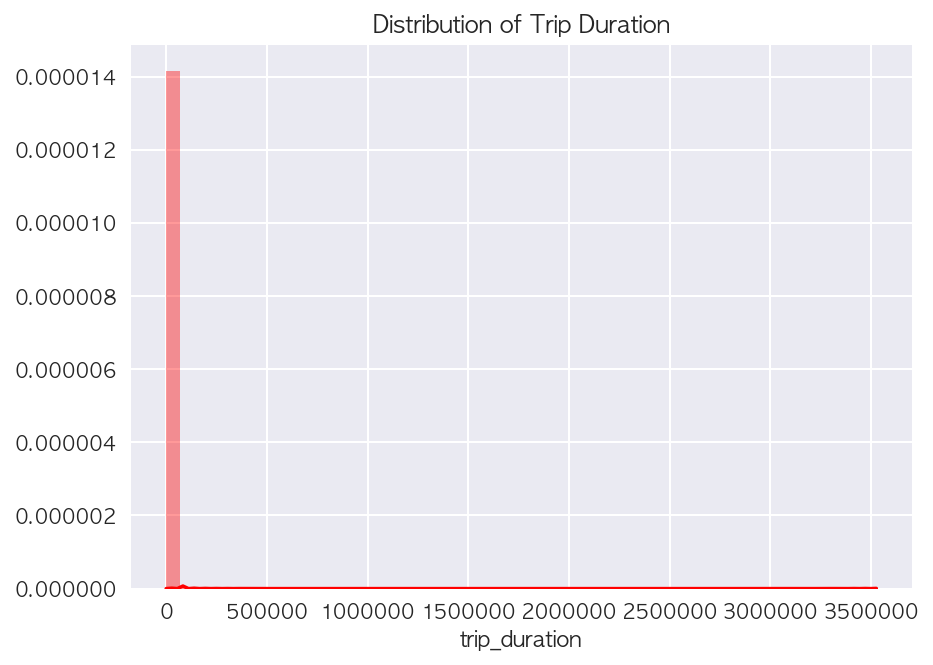

In [109]:
plt.figure(figsize=(7, 5))
sns.distplot(train["trip_duration"], color="r")
plt.title("Distribution of Trip Duration")
plt.show()

In [110]:
# 종속변수/독립변수 분리

X_cols = [col for col in train.columns if col != "trip_duration"]
train_X0 = train[X_cols]
train_y = train[["trip_duration"]]

In [123]:
col_real = ["passenger_count", "distance", "bearing", "pickup_longitude", 
            "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]

col_cats = [col for col in train.columns if col not in col_real]
# ["pickup_hour", "pickup_weekday", "pickup_month", "dropoff_hour", "dropoff_weekday", "dropoff_month", ]
for col in ["pickup_datetime", "dropoff_datetime", "id"]:
    col_cats.remove(col)
col_cats_nontime = ["vendor_id", "store_and_fwd_flag", "working_day"]

In [125]:
col_cats

['vendor_id',
 'store_and_fwd_flag',
 'trip_duration',
 'pickup_month',
 'dropoff_month',
 'pickup_weekday',
 'dropoff_weekday',
 'pickup_hour',
 'dropoff_hour',
 'working_day']

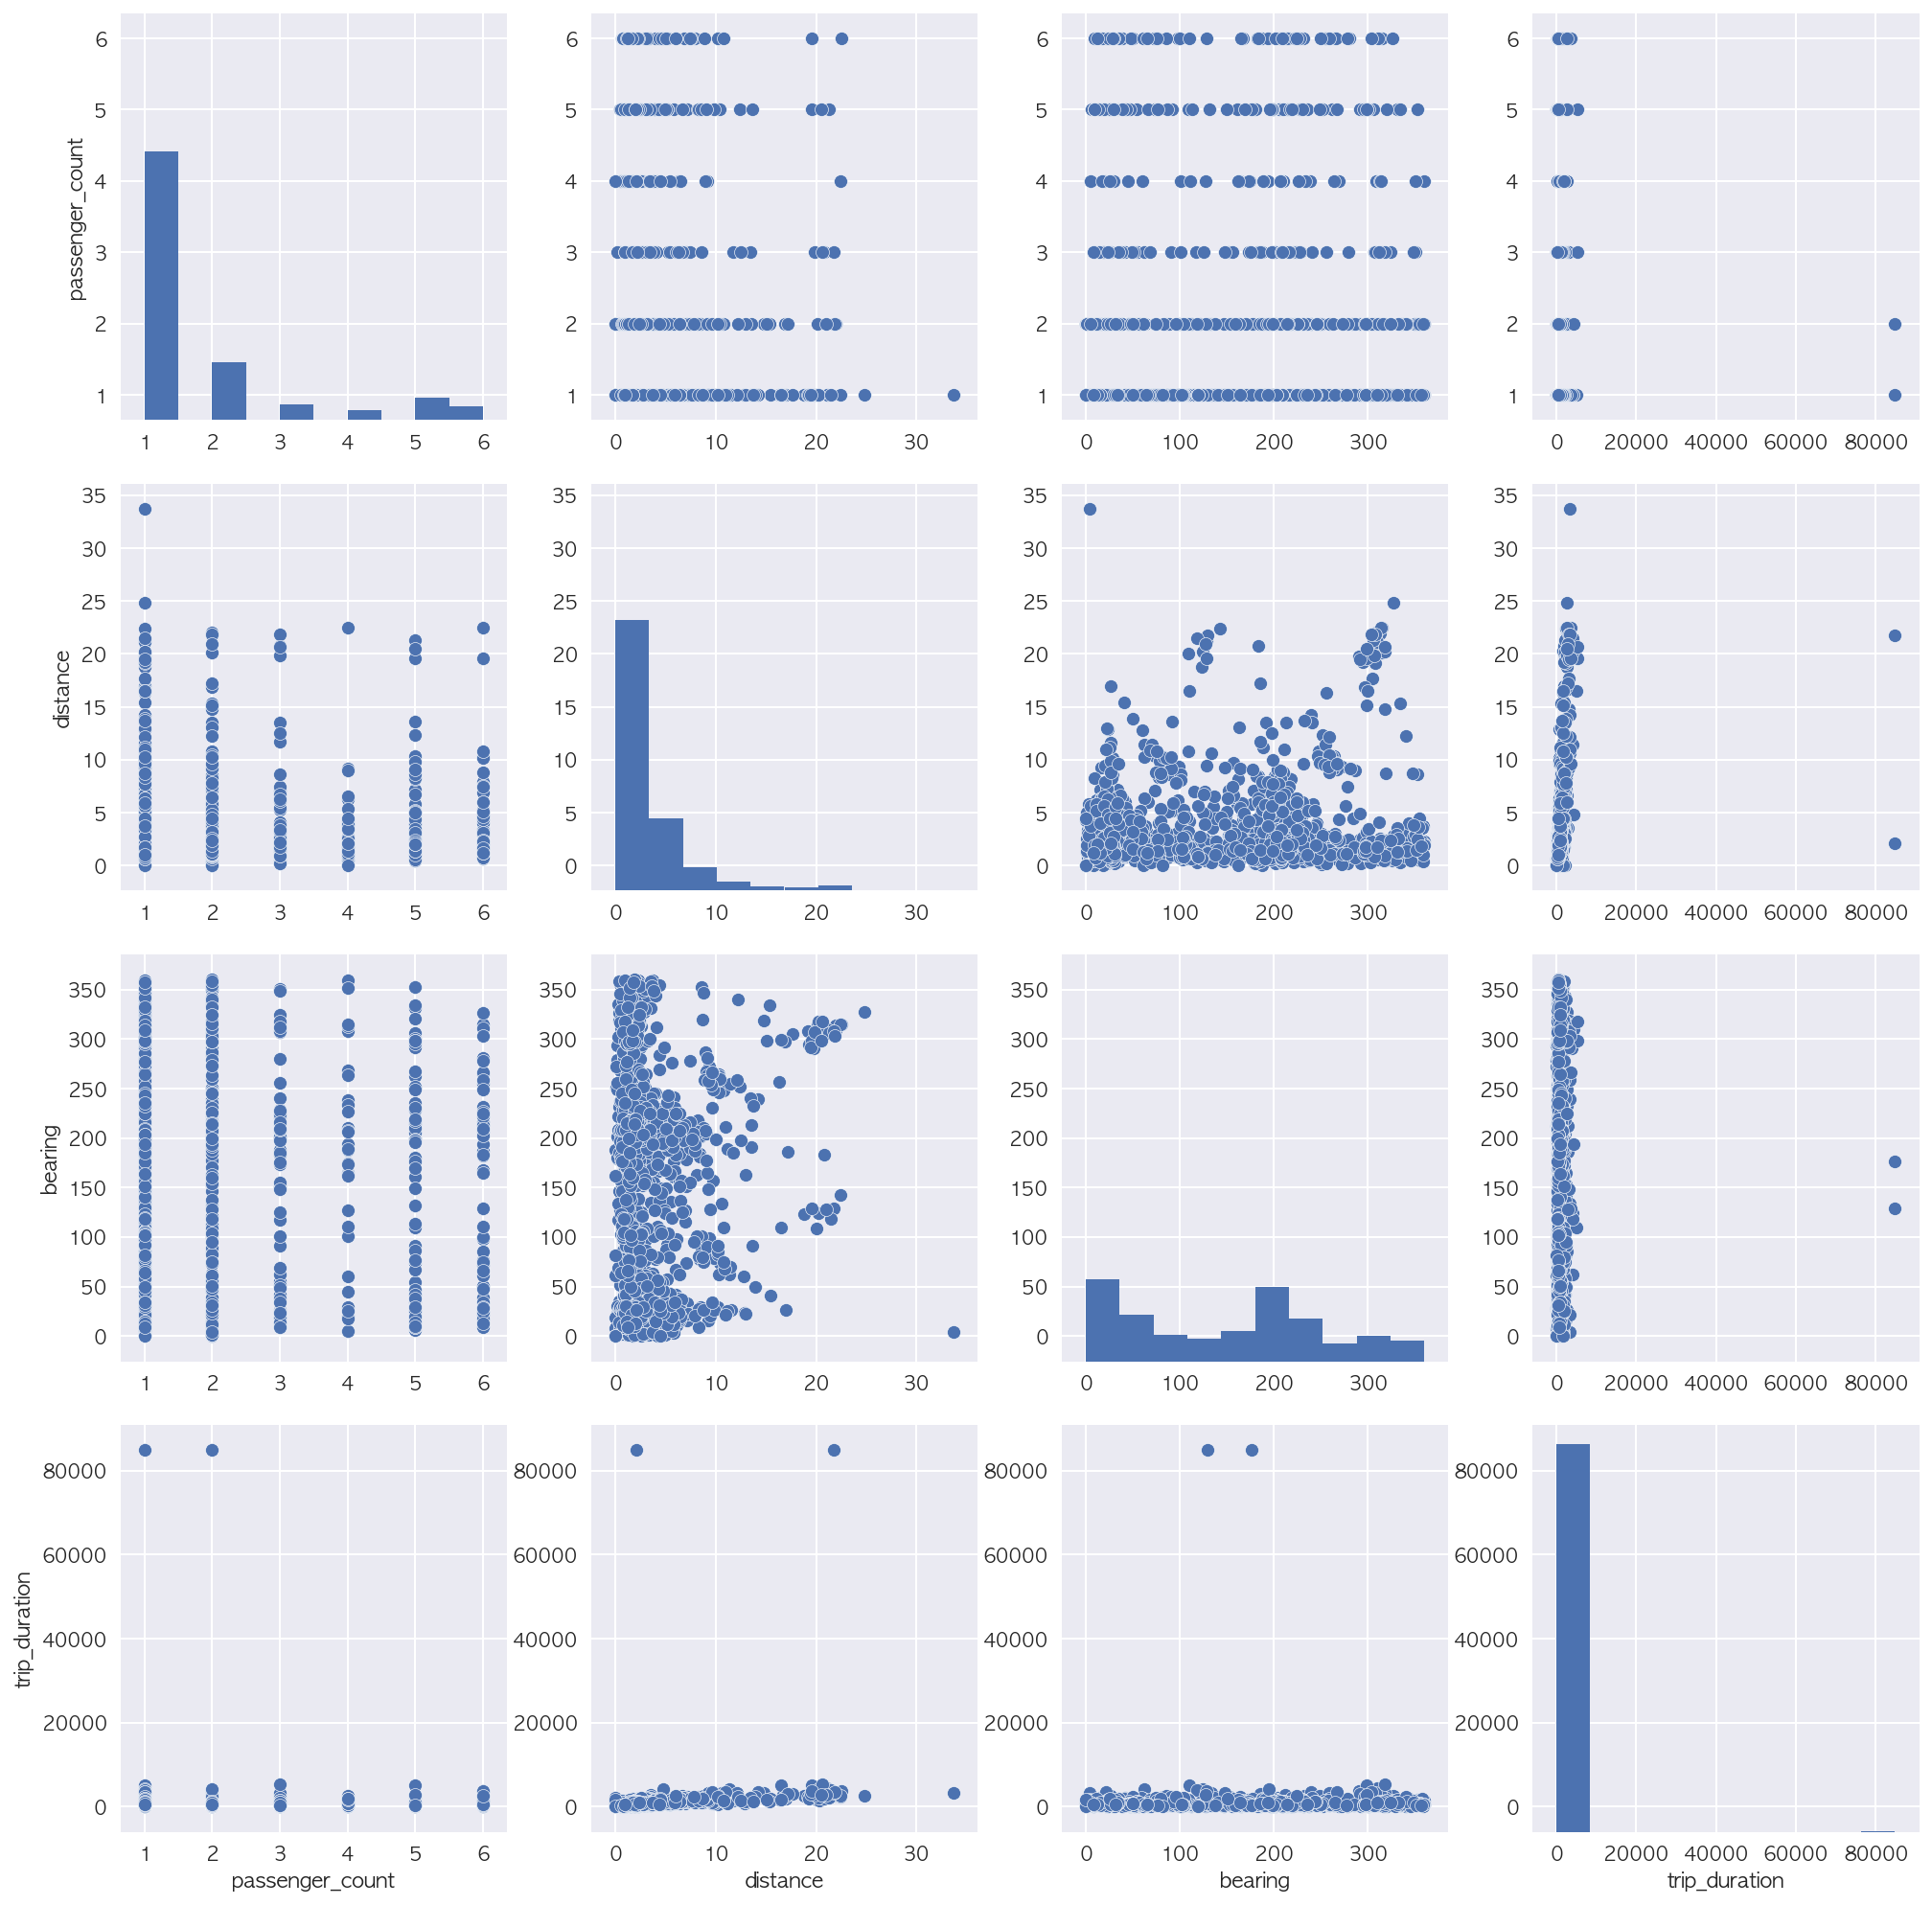

In [157]:
# passenger_count, distance, avg_speed_h

sns.pairplot(pd.concat([train_X0[col_real[:3]], train_y], axis=1)[::1000], size=3.5)
plt.show()

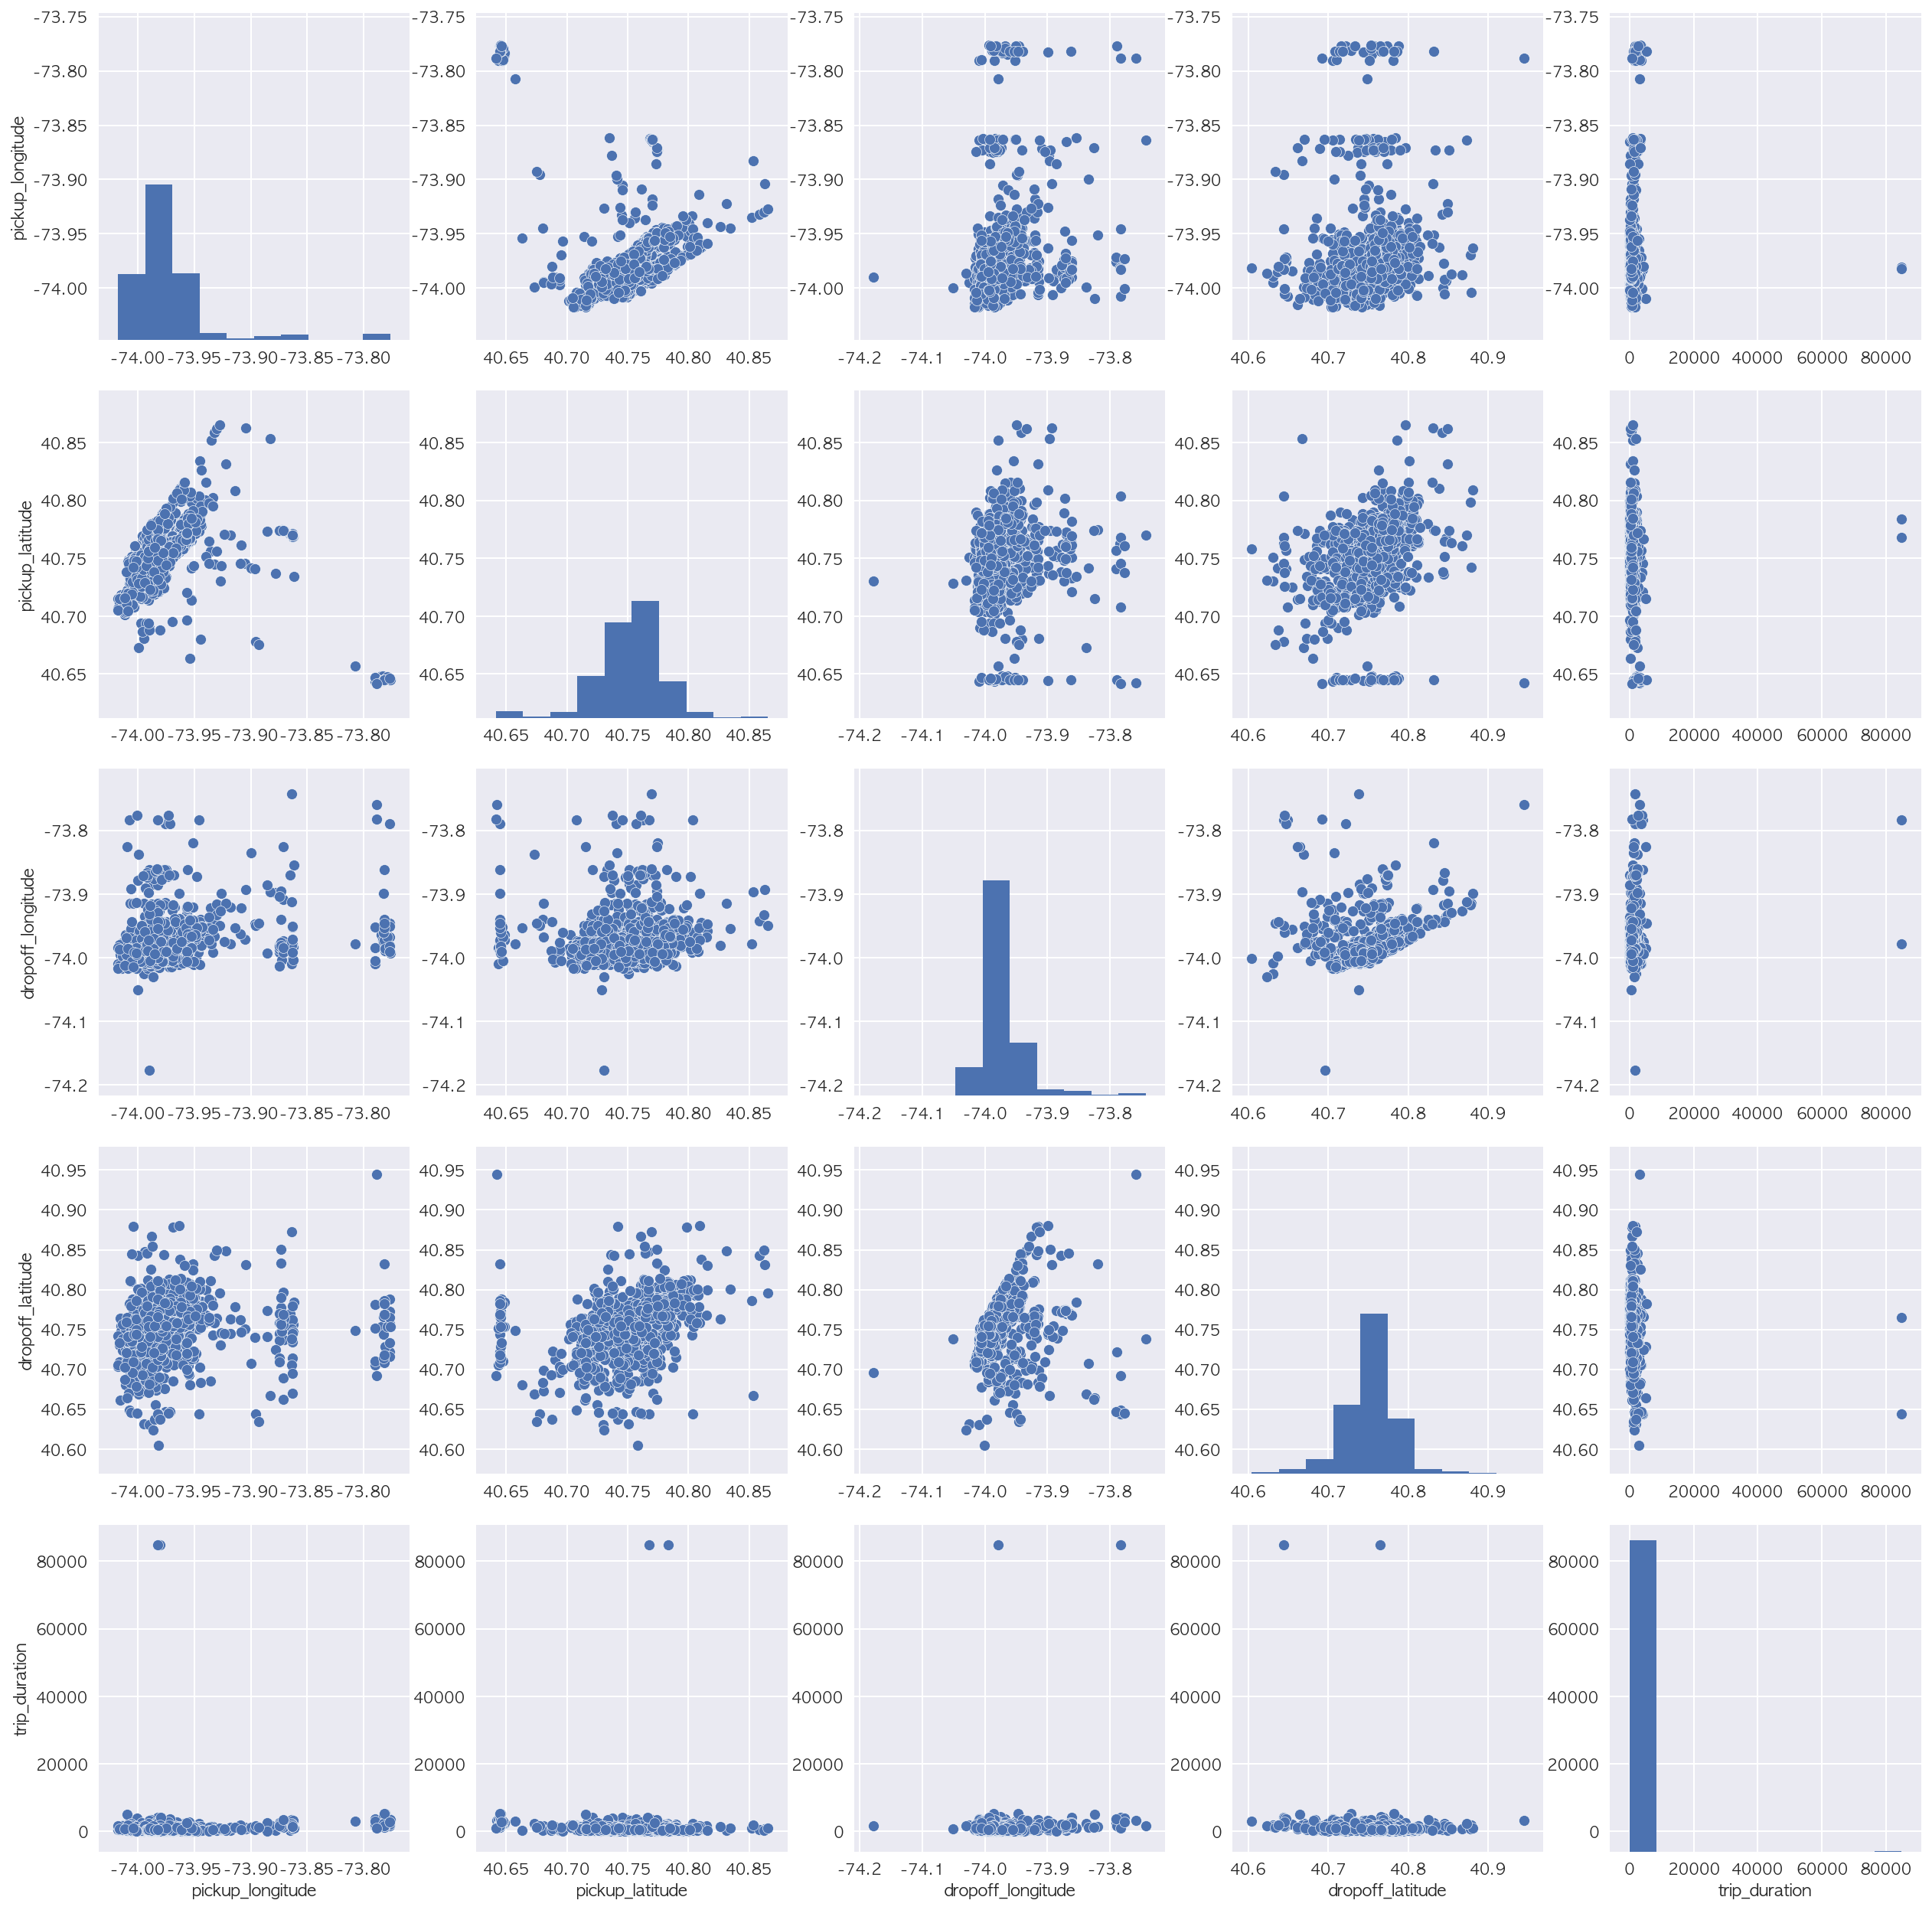

In [158]:
sns.pairplot(pd.concat([train_X0[col_real[3:]], train_y], axis=1)[::1000], size=3.5)
plt.show()

In [159]:
def display_boxplots(start_features, row, col):
    with plt.style.context(('seaborn-darkgrid')):
        f, axes = plt.subplots(row, col, figsize=(12, 6), sharey=True)
        nums = row * col
        start_idx = col_cats_nontime.index(start_features)

        for num, ax in zip(range(nums), axes.flat):
            try: 
                sns.boxplot(x=train_X0[col_cats_nontime[start_idx + num]], y=np.log1p(train_y["trip_duration"]), ax=ax)
                ax.set_ylabel("log of trip duration")
            except:
                pass

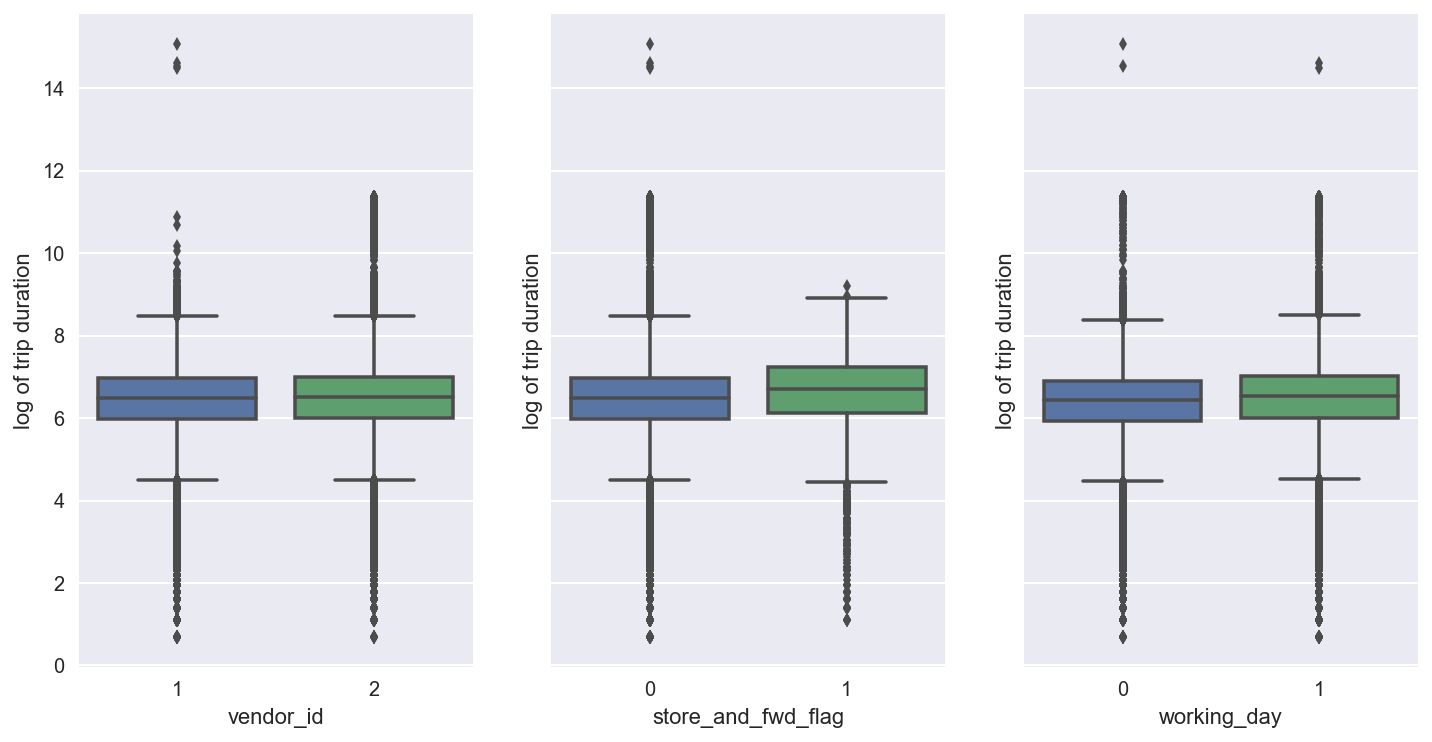

In [160]:
display_boxplots("vendor_id", 1, 3)

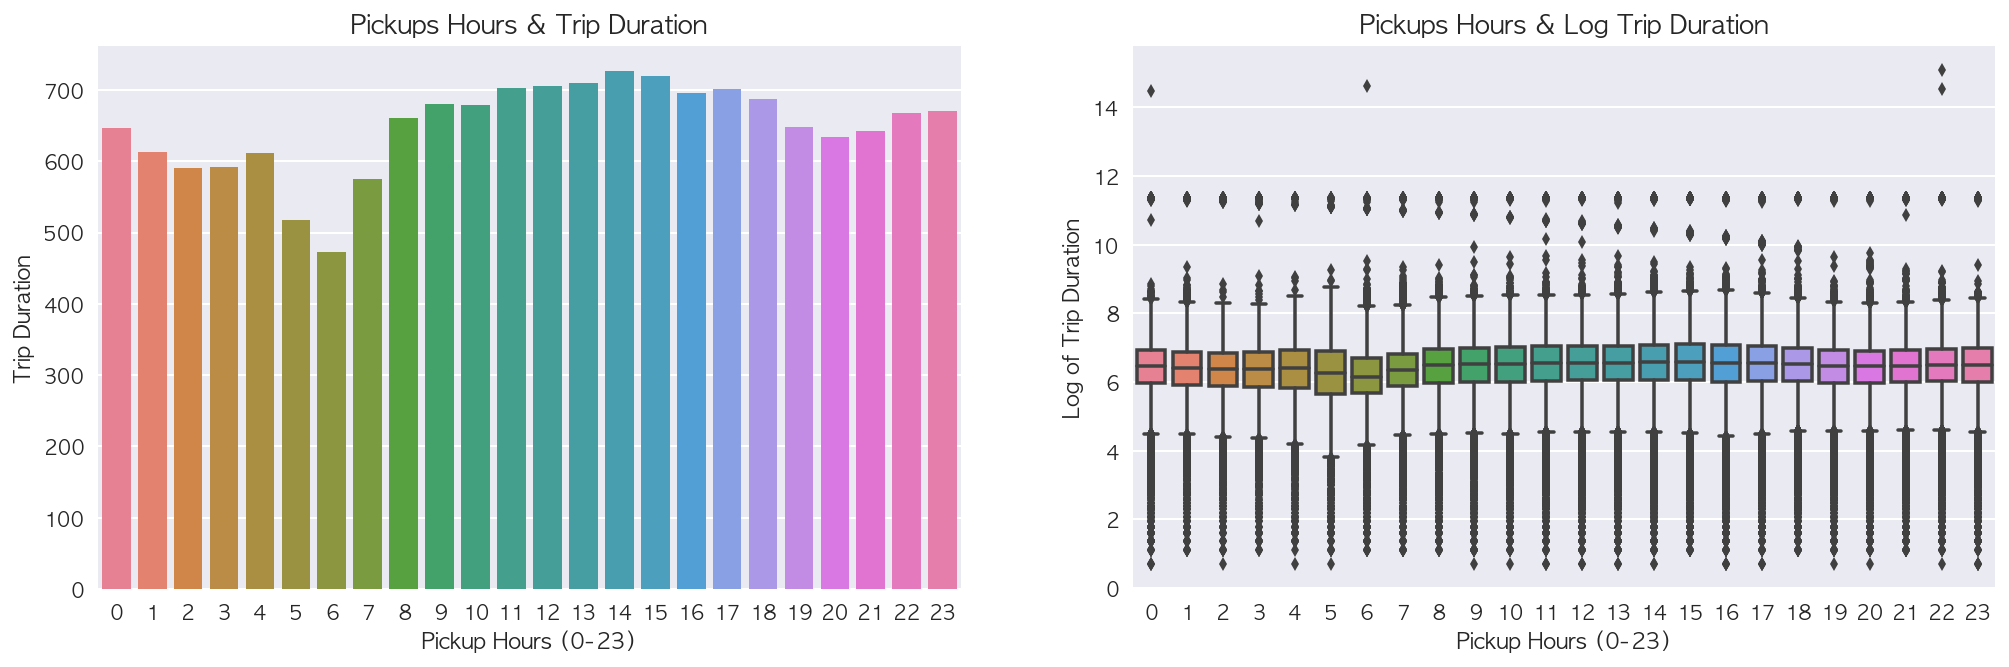

In [170]:
# Trip Duration의 경우, 상위 4개의 값이 워낙 큼. mean이 아닌 mode로 하면 차이는 더 많이 남)
# boxplot으로 보여주는 것도 좋을 것 같음 (단, log 처리하지 않으면 아웃라이어에 영향을 많이 받을 것)

data = train.loc[:, ["pickup_hour", "trip_duration"]].groupby("pickup_hour").median()

plt.figure(figsize=(17, 5))

plt.subplot(121)
sns.barplot(x=data.index, y=data.trip_duration, data=data, palette="husl")
plt.title("Pickups Hours & Trip Duration", fontsize=13)
plt.xlabel("Pickup Hours (0-23)")
plt.ylabel("Trip Duration")


plt.subplot(122)
sns.boxplot(x=train["pickup_hour"], y=np.log1p(train["trip_duration"]), palette="husl")
plt.title("Pickups Hours & Log Trip Duration", fontsize=13)
plt.xlabel("Pickup Hours (0-23)")
plt.ylabel("Log of Trip Duration")

plt.show()

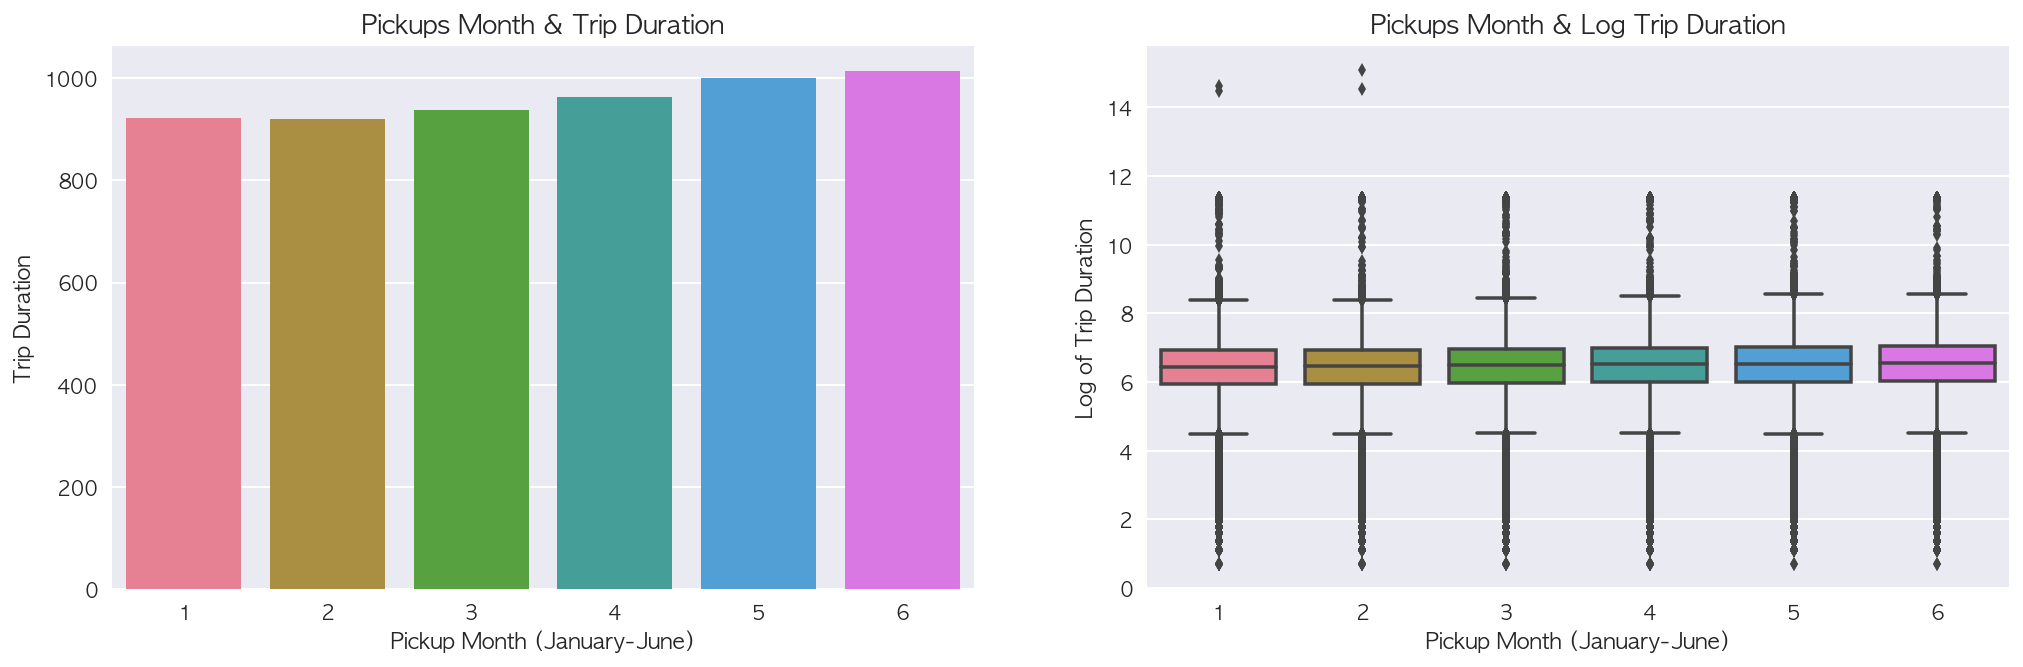

In [175]:
data = train.loc[:, ["pickup_month", "trip_duration"]].groupby("pickup_month").mean()

plt.figure(figsize=(17, 5))

plt.subplot(121)
sns.barplot(x=data.index, y=data.trip_duration, data=data, palette="husl")
plt.title("Pickups Month & Trip Duration", fontsize=13)
plt.xlabel("Pickup Month (January-June)")
plt.ylabel("Trip Duration")

plt.subplot(122)
sns.boxplot(x=train["pickup_month"], y=np.log1p(train["trip_duration"]), palette="husl")
plt.title("Pickups Month & Log Trip Duration", fontsize=13)
plt.xlabel("Pickup Month (January-June)")
plt.ylabel("Log of Trip Duration")

plt.show()

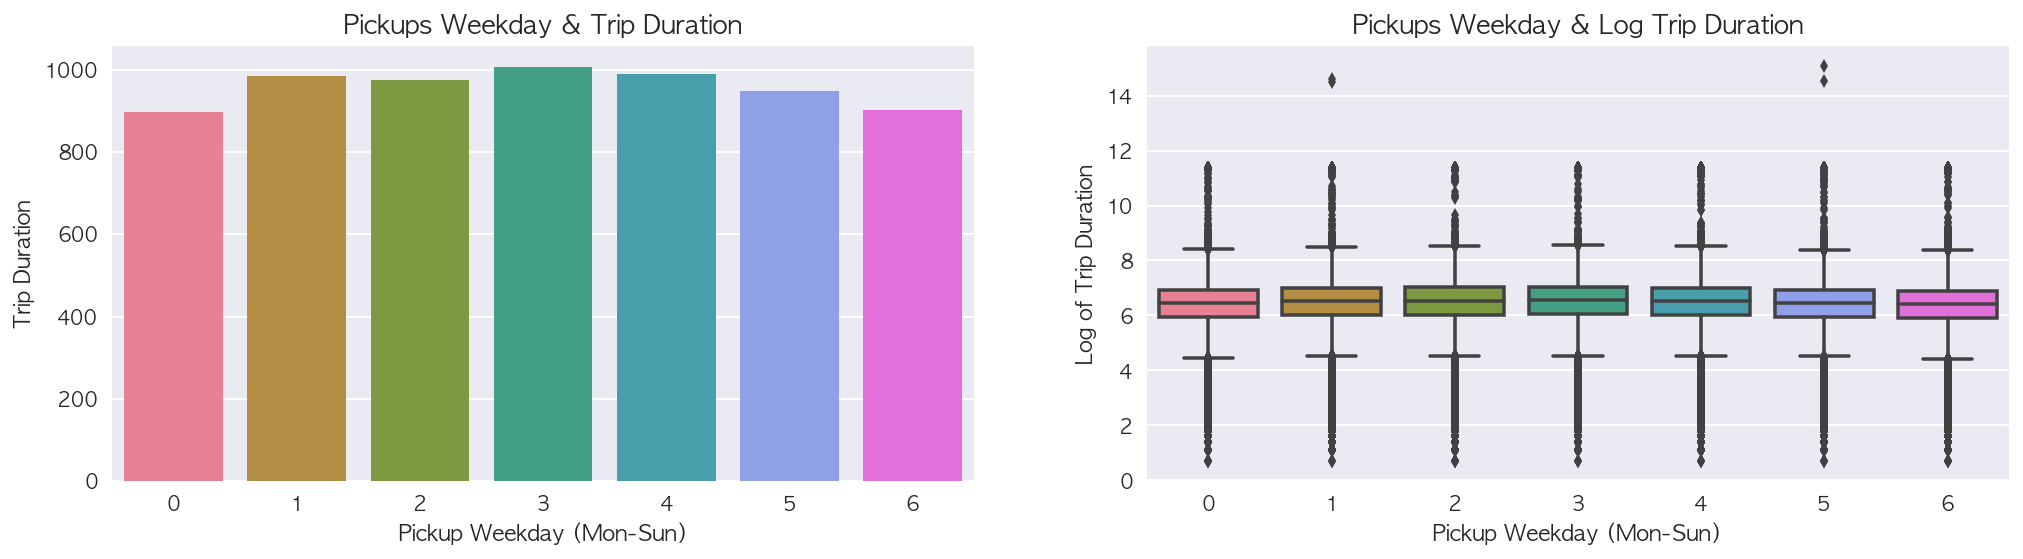

In [173]:
data = train.loc[:, ["pickup_weekday", "trip_duration"]].groupby("pickup_weekday").mean()

plt.figure(figsize=(17, 4))

plt.subplot(121)
sns.barplot(x=data.index, y=data.trip_duration, data=data, palette="husl")
plt.title("Pickups Weekday & Trip Duration", fontsize=13)
plt.xlabel("Pickup Weekday (Mon-Sun)")
plt.ylabel("Trip Duration")

plt.subplot(122)
sns.boxplot(x=train["pickup_weekday"], y=np.log1p(train["trip_duration"]), palette="husl")
plt.title("Pickups Weekday & Log Trip Duration", fontsize=13)
plt.xlabel("Pickup Weekday (Mon-Sun)")
plt.ylabel("Log of Trip Duration")

plt.show()

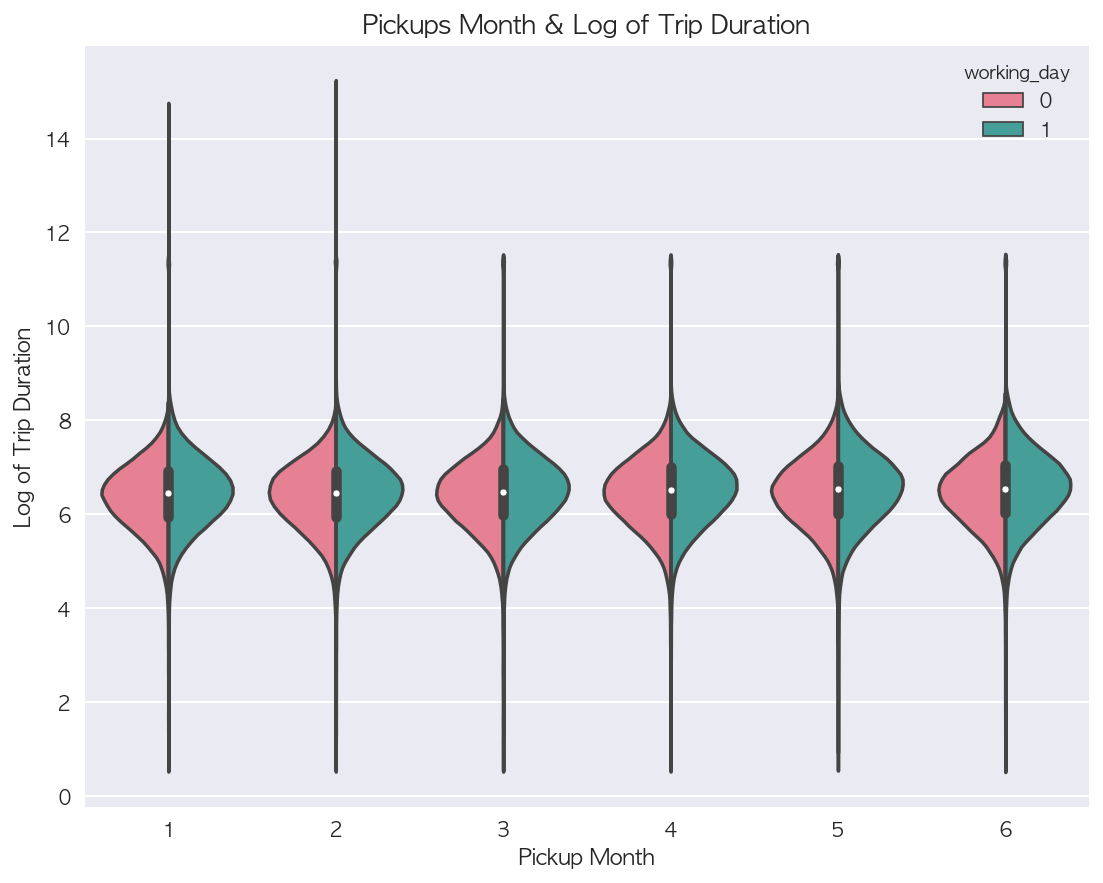

In [180]:
wd = train.loc[:, ["pickup_weekday", "pickup_month", "trip_duration", "working_day"]]

plt.figure(figsize=(9, 7))
sns.violinplot(x=wd["pickup_month"], 
               y=wd["trip_duration"].apply(np.log1p),
               hue="working_day",
               data=wd, palette="husl", split=True)
plt.title("Pickups Month & Log of Trip Duration", fontsize=13)
plt.xlabel("Pickup Month")
plt.ylabel("Log of Trip Duration")
# plt.xticks(range(0, 6), month)
plt.show()